# Generierung synthetischer Daten am Beispiel des Myo Datensatzes

Die zielgerichtete Generierung synthetischer Daten stellt einen Aufgabengebiet dar, der in modernen Anwendungen immer mehr an Bedeutung gewinnt. Lösungsansätze werden immer dann benötigt, wenn datengetriebene Algorithmen in Bereichen angewandt werden sollen, in denen entweder die Nutzung der Daten durch Datenschutzrichtlinien verhindert wird oder die Anzahl der vorliegenden Daten unzureichend ist. In beiden Fällen sollen Muster und Strukturen der erzeugten Datensätze möglichst genau denen der Realität entsprechen.

Der Realdatensatz der Messungen aus dem ITS.ML Projekt „Transferlernen für Handprothesen im Alltagseinsatz“ ist relativ klein und soll durch den Einsatz von ML-basierten Techniken erweitert werden.
Um die Güte der erzeugten Daten anschließend zu bewerten, sollen die Struktur der synthetischen sowie realen Messwerte untersucht und verglichen werden.

Wir verwenden in diesem Notebook die Python-Bibliotheken pickle, numpy, pandas, json, sdv, pomegranate und matplotlib.

Zuerst importieren wir einige der Bibliotheken, die wir allgemein benötigen.

In [1]:
import pickle as pkl
import numpy
import pandas as pd
import json
from sdv import Metadata

Nun laden wir den Datensatz aus dem Projekt „Transferlernen für Handprothesen im Alltagseinsatz“.

In [2]:
traindata = pkl.load(open('train_data.pkl', 'rb'))

Um einen Überblick zu erhalten, schauen wir uns die Daten an:

In [3]:
traindata

{'X_src': array([[ 0.26513725,  0.80925469, -0.17899497, ...,  1.90510437,
          0.6089009 ,  0.06501162],
        [ 0.46436403,  0.60281896, -0.35129274, ...,  1.77168589,
          0.22558731,  0.1078886 ],
        [ 0.55298158, -0.22365066,  0.02378312, ...,  1.04053224,
          0.90712137,  0.2639778 ],
        ...,
        [ 0.51281369,  0.03814471,  0.73968039, ...,  2.14570773,
          0.57873488,  0.21001998],
        [ 0.58509906, -0.82795934, -0.35705888, ...,  1.64587802,
         -0.14940568,  0.17453354],
        [-0.54833626,  0.39404247,  0.10425345, ...,  2.6714668 ,
          1.15903582, -0.04043299]]),
 'Y_src': array([0, 0, 0, ..., 0, 0, 0]),
 'codebook': {0: 'no_movement',
  1: 'hand_open',
  2: 'hand_close',
  3: 'supination',
  4: 'pronation',
  5: 'hand_open+supination',
  6: 'hand_open+pronation',
  7: 'hand_close+supination',
  8: 'hand_close+pronation'}}

In [4]:
numpy.shape(traindata['X_src'])

(1538, 8)

In [5]:
numpy.shape(traindata['Y_src'])

(1538,)

Der Datensatz besteht also aus 1538 Messungen, In `X_src` befinden sich die Messwerte der jeweils 8 Sensoren des Armbands und in `Y_src` die zugehörigen Codes für die aktuelle Handbewegung.

## Multi-Table Modell

Um mit diesen Daten ein Modell trainieren zu können, wandeln wir die in `testdata` enthaltenen Arrays in Pandas DataFrames um und versehen die Tabelle der Messwerte zusätzlich mit einer Spalte, die den Messwerten die zugehörigen Code-Werte per `ìd` zuordnet.

In [6]:
xsrc = pd.DataFrame(traindata['X_src'], columns=["sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8"])
xsrc['id'] = xsrc.index
xsrc['ysrc_id'] = xsrc.index

ysrc = pd.DataFrame(traindata['Y_src'], columns=["code"])
ysrc['id'] = ysrc.index

In [7]:
xsrc

,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,id,ysrc_id
0,0.265137,0.809255,-0.178995,2.746354,3.166690,1.905104,0.608901,0.065012,0,0
1,0.464364,0.602819,-0.351293,3.043960,3.325195,1.771686,0.225587,0.107889,1,1
2,0.552982,-0.223651,0.023783,1.516311,2.093622,1.040532,0.907121,0.263978,2,2
3,0.229242,0.833957,1.271798,3.847606,4.113984,2.097045,1.042262,-0.876377,3,3
4,0.192337,0.365837,0.897946,3.072840,3.754567,3.668033,1.467112,0.263822,4,4
...,...,...,...,...,...,...,...,...,...,...
1533,0.335240,1.033154,1.544523,2.227198,4.152546,3.885886,1.790236,0.186224,1533,1533
1534,0.044641,0.018909,0.594428,1.395340,3.335126,3.024916,0.721799,-0.014882,1534,1534
1535,0.512814,0.038145,0.739680,0.719289,2.318140,2.145708,0.578735,0.210020,1535,1535
1536,0.585099,-0.827959,-0.357059,1.015795,2.322458,1.645878,-0.149406,0.174534,1536,1536


In [8]:
ysrc

,code,id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
1533,0,1533
1534,0,1534
1535,0,1535
1536,0,1536


Nun erstellen wir für unser erstes Modell ein `Metadata` Objekt, welches die Tabellenstruktur abbildet.

In [9]:
metadata = Metadata()

In [10]:
metadata = Metadata()

metadata.add_table(
    name='ysrc',
    data=ysrc,
    primary_key='id'
 )

metadata.add_table(
    name='xsrc',
    data=xsrc,
    primary_key='id',
    parent='ysrc',
    foreign_key='ysrc_id'
 )

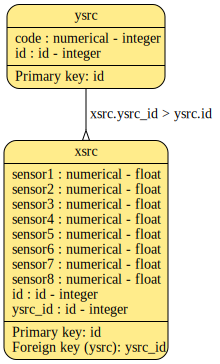

In [11]:
metadata.visualize()

Jetzt könnnen wir mit Erstellung und Training des Modells fortfahren. Wir nutzen dazu den `HMA1` Algorithmus des `sdv` Pakets. `HMA1` ist ein Algorithmus, der auf relationalen Datensätzen tabellenweise ein auf Copula-Funktionen basierendes Modell anlernt.

In [12]:
from sdv.relational import HMA1

tables = {'xsrc': xsrc, 'ysrc': ysrc}
model = HMA1(metadata)
model.fit(tables)

Wir können nun einfach einen neuen Datensatz generieren:

In [13]:
new_data = model.sample()

In [14]:
new_data

{'ysrc':       code    id
 0        1     0
 1        3     1
 2        4     2
 3        0     3
 4        2     4
 ...    ...   ...
 1533     3  1533
 1534     2  1534
 1535     3  1535
 1536     6  1536
 1537     0  1537
 
 [1538 rows x 2 columns],
 'xsrc':        sensor1   sensor2   sensor3   sensor4   sensor5   sensor6   sensor7  \
 0    -1.015263 -1.078788 -1.160017  0.268566  1.033242  1.407009  1.330266   
 1     1.513283  3.371709  1.771437  2.150269  2.641411  3.519991  2.267807   
 2     5.786539  7.915418  4.764807  4.106341  3.187304  4.372656  5.559177   
 3     0.718749 -0.049659  1.022716  1.782423  2.353326  1.378287 -0.840084   
 4     3.008702  5.051037  2.938128  5.147301  3.641241  3.053161  3.796566   
 ...        ...       ...       ...       ...       ...       ...       ...   
 1533  2.638629  3.806717  3.275438  5.434154  4.967606  4.449028  4.049600   
 1534  1.807749  2.071611  1.440442  0.735291  1.854233  1.830917  1.409851   
 1535  4.459297  5.217487  5.

Im Folgenden wollen wir die Güte der erzeugten Daten untersuchen. Dazu betrachten wir zuerst die von `sdv` mitgelieferte `evaluate` Funktion, die eine Reihe von standartisierten Evaluationsmethoden anwendet.

In [15]:
from sdv.evaluation import evaluate
evaluate(new_data, tables, metadata=metadata, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.802259,0.802259,0.0,1.0,MAXIMIZE,None
2,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,0.802259,0.802259,0.0,1.0,MAXIMIZE,None
3,LogisticDetection,LogisticRegression Detection,0.901163,0.901163,0.0,1.0,MAXIMIZE,None
4,SVCDetection,SVC Detection,0.415602,0.415602,0.0,1.0,MAXIMIZE,None
5,BNLikelihood,BayesianNetwork Likelihood,NaN,NaN,0.0,1.0,MAXIMIZE,Please install pomegranate with `pip install p...
6,BNLogLikelihood,BayesianNetwork Log Likelihood,NaN,NaN,-inf,0.0,MAXIMIZE,Please install pomegranate with `pip install p...
7,LogisticParentChildDetection,LogisticRegression Detection,0.841946,0.841946,0.0,1.0,MAXIMIZE,None
8,SVCParentChildDetection,SVC Detection,0.120102,0.120102,0.0,1.0,MAXIMIZE,None


Während einige Verfahren wie zB. der `KSTest` ein einigermaßen gutes Ergebnis liefern, erhalten wir bei der `SVCDetection` und gerade bei der `SVCParentChildDetection` ein schlechtes Ergebnis.

Um etwas mehr Einblick zu erhalten, versuchen wir nun die Daten zu visualisieren und dabei manuell zu untersuchen. Wir erzeugen die Tabellen `results_o` und `results_s`, die die originalen und synthetisierten Daten in jeweils einer Tabelle zusammenfassen.

In [16]:
results_o = xsrc
results_o['code'] = ysrc['code']
results_o = results_o.drop('ysrc_id', axis=1)

results_s = new_data['xsrc']
results_s['code'] = new_data['ysrc']['code']
results_s = results_s.drop('ysrc_id', axis=1)

Zunächst erzeugen wir Mittelwerte und Standardabweichungen aller Messungen (also für alle Codes aus der ursprünglichen `Y_src` Tabelle zusammengefasst) und plotten diese für jeden Sensor. Die Mittelwerde befinden sich dabei in der linken und die Standardabweichungen in der rechten Tabelle.

<AxesSubplot:>

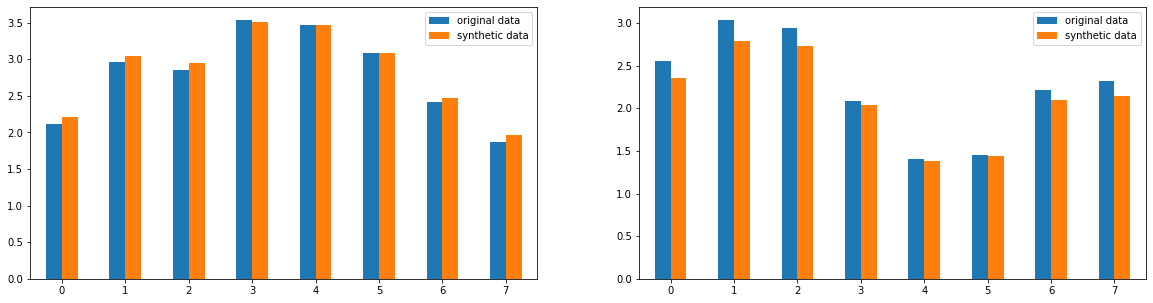

In [17]:
results_combined_mean = pd.DataFrame(columns=['original data', 'synthetic data'])
results_combined_std = pd.DataFrame(columns=['original data', 'synthetic data'])

temp = results_o.mean()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_combined_mean['original data'] = temp.tolist()

temp = results_s.mean()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_combined_mean['synthetic data'] = temp.tolist()

temp = results_o.std()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_combined_std['original data'] = temp.tolist()

temp = results_s.std()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_combined_std['synthetic data'] = temp.tolist()


import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

results_combined_mean.plot.bar(rot=0, ax=axes[0], figsize=(20,5))
results_combined_std.plot.bar(rot=0, ax=axes[1])

Gezeigt werden die Werte für alle Handbewegung zusammengenommen, für die jeweils 8 Sensorwerte. Originaldaten in blau, synthetisch generierte Daten in orange; links: Mittelwerte; rechts: Standardabweichungen.
Diese Ergebnisse sehen zunächst sehr gut aus. Viel wichtiger für eine Qualitätsbeurteilung wäre es allerdings, wenn wir diese Plots für jeden Code aus `Y_src` separat anfertigen.
Dies tun wir im Folgenden. Die Plots sind dabei wie folgt angeordnet: In der linken Spalte sind die Mittelwerte und in der rechten die Standardabweichungen dargestellt. Die einzelnen Reihen bezeichnen die Codes 0 - 8.

In [18]:
results_codes_mean = []
results_codes_std = []

for i in range(9):
    results_codes_mean.insert(i, pd.DataFrame(columns=['original data', 'synthetic data']))
    results_codes_std.insert(i, pd.DataFrame(columns=['original data', 'synthetic data']))
    
    temp = results_o[results_o['code'] == i].mean()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_codes_mean[i]['original data'] = temp.tolist()
    
    temp = results_s[results_s['code'] == i].mean()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_codes_mean[i]['synthetic data'] = temp.tolist()
    
    temp = results_o[results_o['code'] == i].std()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_codes_std[i]['original data'] = temp.tolist()
    
    temp = results_s[results_s['code'] == i].std()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_codes_std[i]['synthetic data'] = temp.tolist()
    

In [19]:
results_codes_mean[0]

,original data,synthetic data
0,0.169780,0.443639
1,0.538740,0.747981
2,0.638189,0.782122
3,2.198799,2.122363
4,2.869728,2.929972
5,2.386387,2.330638
6,0.909510,0.732896
7,0.096173,0.546454


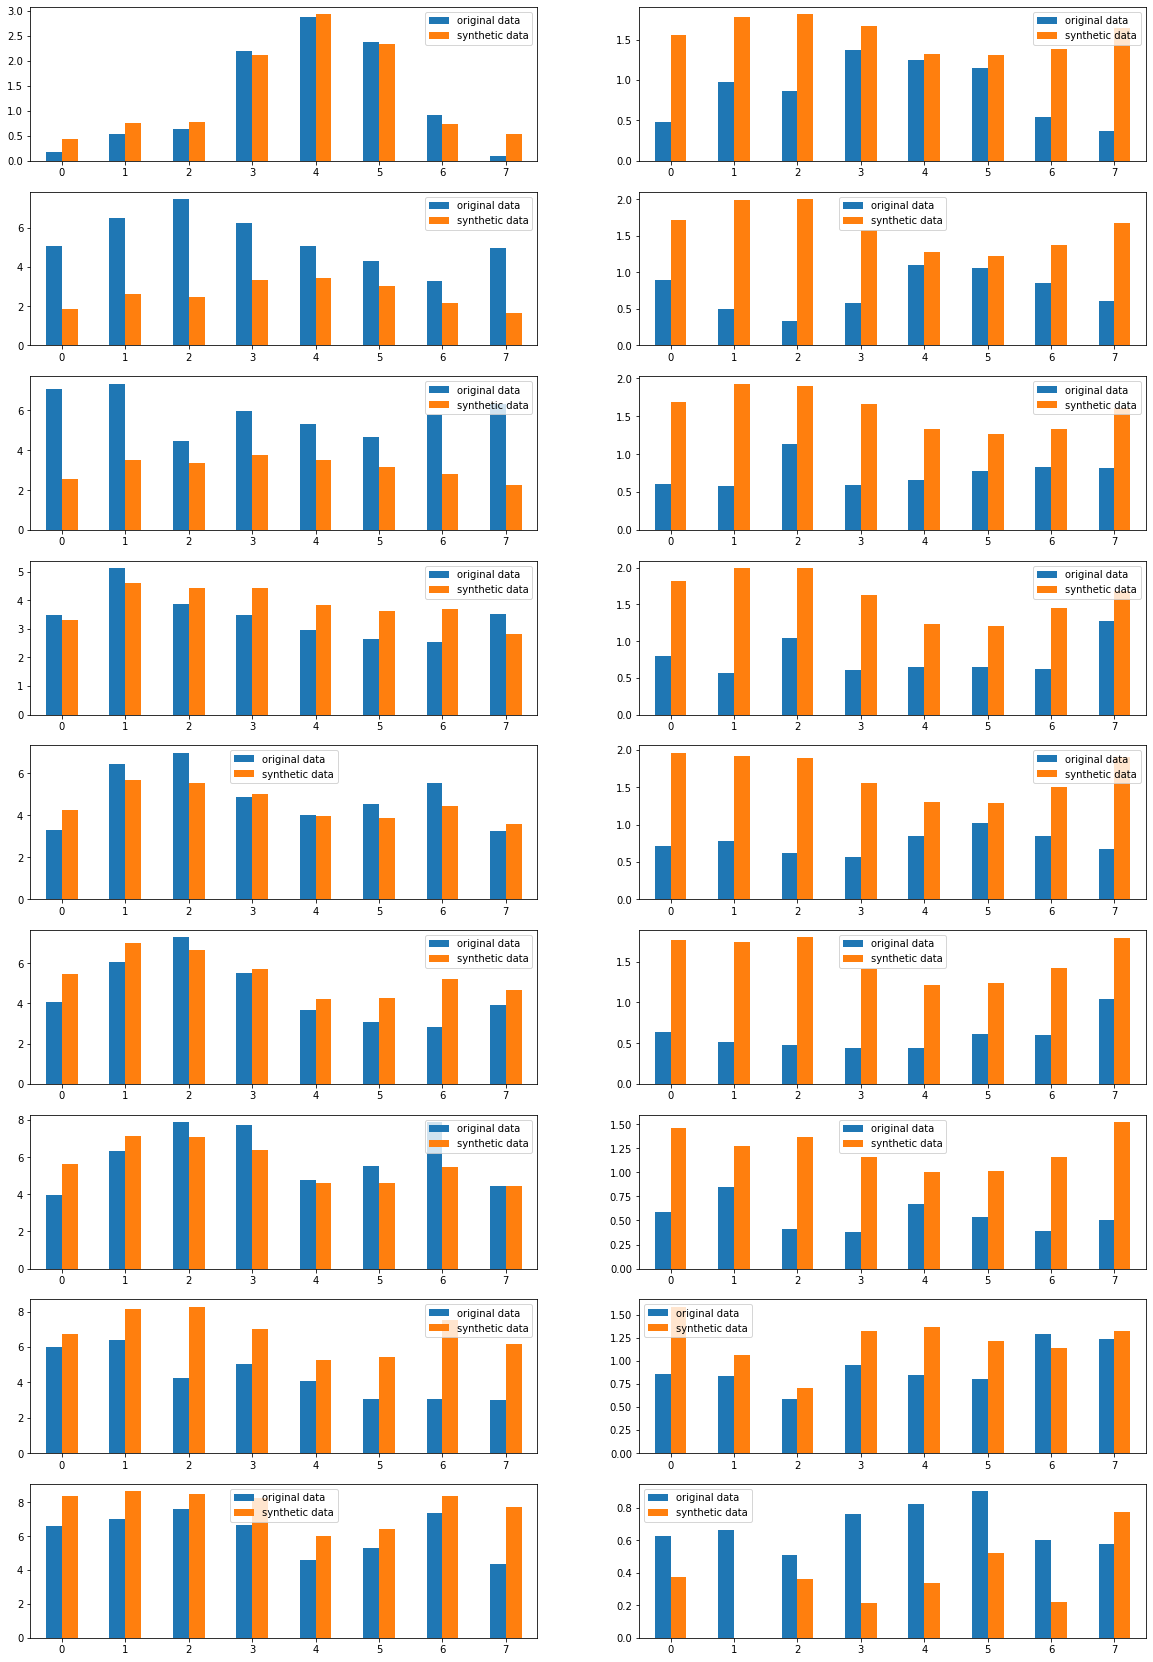

In [20]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(9, 2)

for i in range(9):
    results_codes_mean[i].plot.bar(rot=0, ax=axes[i,0], figsize=(20,30))
    results_codes_std[i].plot.bar(rot=0, ax=axes[i,1])

Jede Zeile entspricht einer Handbewegung mit den jeweils 8 Sensorwerten und zeigt die Werte für Originaldaten, sowie die synthetisch generierten Daten; linke Spalte: Mittelwerte; rechte Spalte: Standardabweichungen.
Wie wir den Plots entnehmen können, beinhalten die Mittelwerte der Codes 1 und 2 starke Abweichungen, während die Standardabweichungen für alle Codes relativ stark Abweichen.
Für Code 8 ist keine Standardabweichung eingezeichnet, da nur ein Datenpunkt in den synthetischen Daten existiert. Die Modelle (sowohl Multi-Table als auch Single-Table) neigen dazu, wenige bis garkeine Daten für Code 8 zu erzeugen.

Selbst bei besserer Übereinstimmung der Plots wäre diese Art der Untersuchung immernoch unzulänglich, da zB. multimodale Verteilungen nicht durch Mittelwert und Standardabweichung erfasst werden können.
In diesem Notebook werden wir die Evaluierung allerdings nicht weiter ausweiten.

## Single-Table Modell

Zum Vergleich trainieren wir noch ein weiteres Modell, welches mit nur einer Tabelle angelernt wird. Wir fügen die Codes also einfach als Spalte zu den Messwerten hinzu.

In [21]:
xsrc_single = pd.DataFrame(traindata['X_src'], columns=["sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8"])
xsrc_single['id'] = xsrc_single.index
xsrc_single['code'] = traindata['Y_src']

In [22]:
xsrc_single

,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,id,code
0,0.265137,0.809255,-0.178995,2.746354,3.166690,1.905104,0.608901,0.065012,0,0
1,0.464364,0.602819,-0.351293,3.043960,3.325195,1.771686,0.225587,0.107889,1,0
2,0.552982,-0.223651,0.023783,1.516311,2.093622,1.040532,0.907121,0.263978,2,0
3,0.229242,0.833957,1.271798,3.847606,4.113984,2.097045,1.042262,-0.876377,3,0
4,0.192337,0.365837,0.897946,3.072840,3.754567,3.668033,1.467112,0.263822,4,0
...,...,...,...,...,...,...,...,...,...,...
1533,0.335240,1.033154,1.544523,2.227198,4.152546,3.885886,1.790236,0.186224,1533,0
1534,0.044641,0.018909,0.594428,1.395340,3.335126,3.024916,0.721799,-0.014882,1534,0
1535,0.512814,0.038145,0.739680,0.719289,2.318140,2.145708,0.578735,0.210020,1535,0
1536,0.585099,-0.827959,-0.357059,1.015795,2.322458,1.645878,-0.149406,0.174534,1536,0


Nun nutzen wir den `TVAE` Algorithmus der `sdv` Umgebung. Dieser ist ein auf Variational Autoencodern basierender Deep Learning Algorithmus.

In [23]:
from sdv.tabular import TVAE

# sdv verwendet unter der Haube sklearn; 
# dies führt zu Warnungen, auch wenn der fitting Prozess erfolgreich war:
# um einen sauberen Output zu erhalten, ignorieren wir sie hier
import warnings
warnings.filterwarnings('ignore')

ft = {
    'sensor1' : 'float',
    'sensor2' : 'float',
    'sensor3' : 'float',
    'sensor4' : 'float',
    'sensor5' : 'float',
    'sensor6' : 'float',
    'sensor7' : 'float',
    'sensor8' : 'float',
    'id' : 'integer',
    'code' : 'label_encoding',
}

model = TVAE(primary_key='id', field_transformers=ft)
model.fit(xsrc_single)

Die hier geworfenen Warnings stammen aus der Bibliothek `sklearn`, die von `sdv` unter der Haube verwendet wird. Das Modell funktioniert trotzdem.
Wir samplen im nächsten Schritt solange 10000 Messreihen, bis auch mindestens eine Reihe für Code 8 existiert. Dieses Modell neigt dazu, öfter selbst bei derartig vielen Messwerten keine solche Messreihe zu produzieren.

In [24]:
new_data_single = model.sample(10000)

while len(new_data_single[new_data_single['code'] == 8]) == 0:
    new_data_single = model.sample(10000)

In [25]:
new_data_single

,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,id,code
0,0.077300,0.155145,-0.235172,0.896167,3.258317,1.352415,0.955263,0.508599,0,0
1,3.940562,5.342724,4.445383,3.590619,2.926284,3.190840,1.457349,4.783652,1,0
2,0.520169,0.036460,1.120964,1.036763,3.225016,4.498475,0.830262,0.169880,2,0
3,-0.020448,0.413916,4.606356,4.201559,5.167768,2.585678,1.696093,-0.072954,3,0
4,5.721844,6.550624,8.262909,6.624782,4.966608,6.970423,6.481625,5.336308,4,6
...,...,...,...,...,...,...,...,...,...,...
9995,7.941483,6.374199,7.015059,8.360218,5.797252,5.335393,3.424359,5.588440,9995,7
9996,6.304368,5.663391,4.313674,3.794710,3.447888,1.862818,2.992902,4.609239,9996,2
9997,3.521226,5.216243,2.378541,3.862991,3.629980,2.829953,2.085646,4.748873,9997,2
9998,5.283765,6.740241,7.819204,6.181201,3.754815,4.077370,2.982570,4.243550,9998,1


In [26]:
len(new_data_single[new_data_single['code'] == 8])

3

Wie zuvor betrachten wir zuerst die `evaluate`Funktion von `sdv`.

In [27]:
from sdv.evaluation import evaluate
evaluate(new_data_single, xsrc_single, aggregate=False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,BNLogLikelihood,BayesianNetwork Log Likelihood,NaN,NaN,-inf,0.0,MAXIMIZE,Please install pomegranate with `pip install p...
1,LogisticDetection,LogisticRegression Detection,0.148104,0.148104,0.0,1.0,MAXIMIZE,None
2,SVCDetection,SVC Detection,0.084748,0.084748,0.0,1.0,MAXIMIZE,None
3,BinaryDecisionTreeClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
4,BinaryAdaBoostClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
5,BinaryLogisticRegression,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
6,BinaryMLPClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
7,MulticlassDecisionTreeClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
8,MulticlassMLPClassifier,None,NaN,NaN,0.0,1.0,MAXIMIZE,`target` must be passed either directly or ins...
9,LinearRegression,None,NaN,NaN,-inf,1.0,MAXIMIZE,`target` must be passed either directly or ins...


Viele Evaluationsmethoden scheinen mit unserem Datensatz nicht zu funktionieren.
Die, die funktionieren, liefern uns kein eindeutiges Ergebnis.

Also wiederholen wir die Visualisierung mit Plots.
Wieder starten wir mit Mittelwert und Standardabweichung auf dem gesamten Datensatz.

<AxesSubplot:>

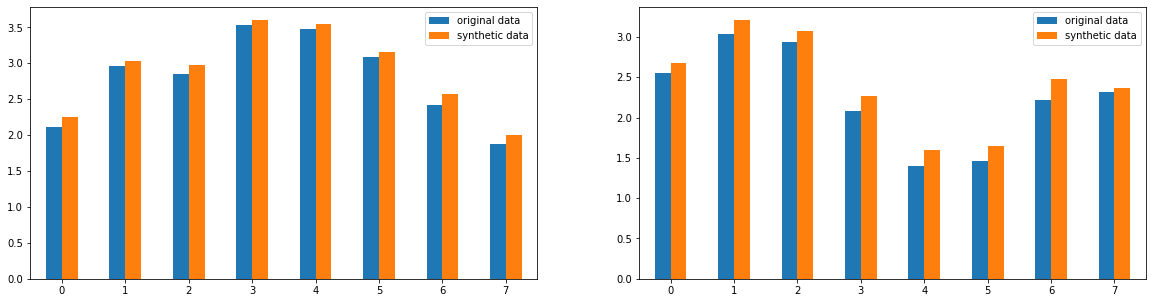

In [28]:
results_single_combined_mean = pd.DataFrame(columns=['original data', 'synthetic data'])
results_single_combined_std = pd.DataFrame(columns=['original data', 'synthetic data'])

temp = xsrc_single.mean()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_single_combined_mean['original data'] = temp.tolist()

temp = new_data_single.mean()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_single_combined_mean['synthetic data'] = temp.tolist()

temp = xsrc_single.std()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_single_combined_std['original data'] = temp.tolist()

temp = new_data_single.std()
temp = temp.drop(labels=['code'])
temp = temp.drop(labels=['id'])
results_single_combined_std['synthetic data'] = temp.tolist()


import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)

results_single_combined_mean.plot.bar(rot=0, ax=axes[0], figsize=(20,5))
results_single_combined_std.plot.bar(rot=0, ax=axes[1])

Die Ergebnisse sind, wie zuvor schon, auf den ersten Blick sehr gut. Nun fahren wir mit der Visualisierung für die einzelnen Codes fort.

In [29]:
results_single_codes_mean = []
results_single_codes_std = []

for i in range(9):
    results_single_codes_mean.insert(i, pd.DataFrame(columns=['original data', 'synthetic data']))
    results_single_codes_std.insert(i, pd.DataFrame(columns=['original data', 'synthetic data']))
    
    temp = xsrc_single[xsrc_single['code'] == i].mean()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_single_codes_mean[i]['original data'] = temp.tolist()
    
    temp = new_data_single[new_data_single['code'] == i].mean()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_single_codes_mean[i]['synthetic data'] = temp.tolist()
    
    temp = xsrc_single[xsrc_single['code'] == i].std()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_single_codes_std[i]['original data'] = temp.tolist()
    
    temp = new_data_single[new_data_single['code'] == i].std()
    temp = temp.drop(labels=['code'])
    temp = temp.drop(labels=['id'])
    results_single_codes_std[i]['synthetic data'] = temp.tolist()

In [30]:
results_single_codes_mean[0]

,original data,synthetic data
0,0.169780,0.553564
1,0.538740,0.880113
2,0.638189,1.075197
3,2.198799,2.351341
4,2.869728,2.830499
5,2.386387,2.384868
6,0.909510,1.081562
7,0.096173,0.479883


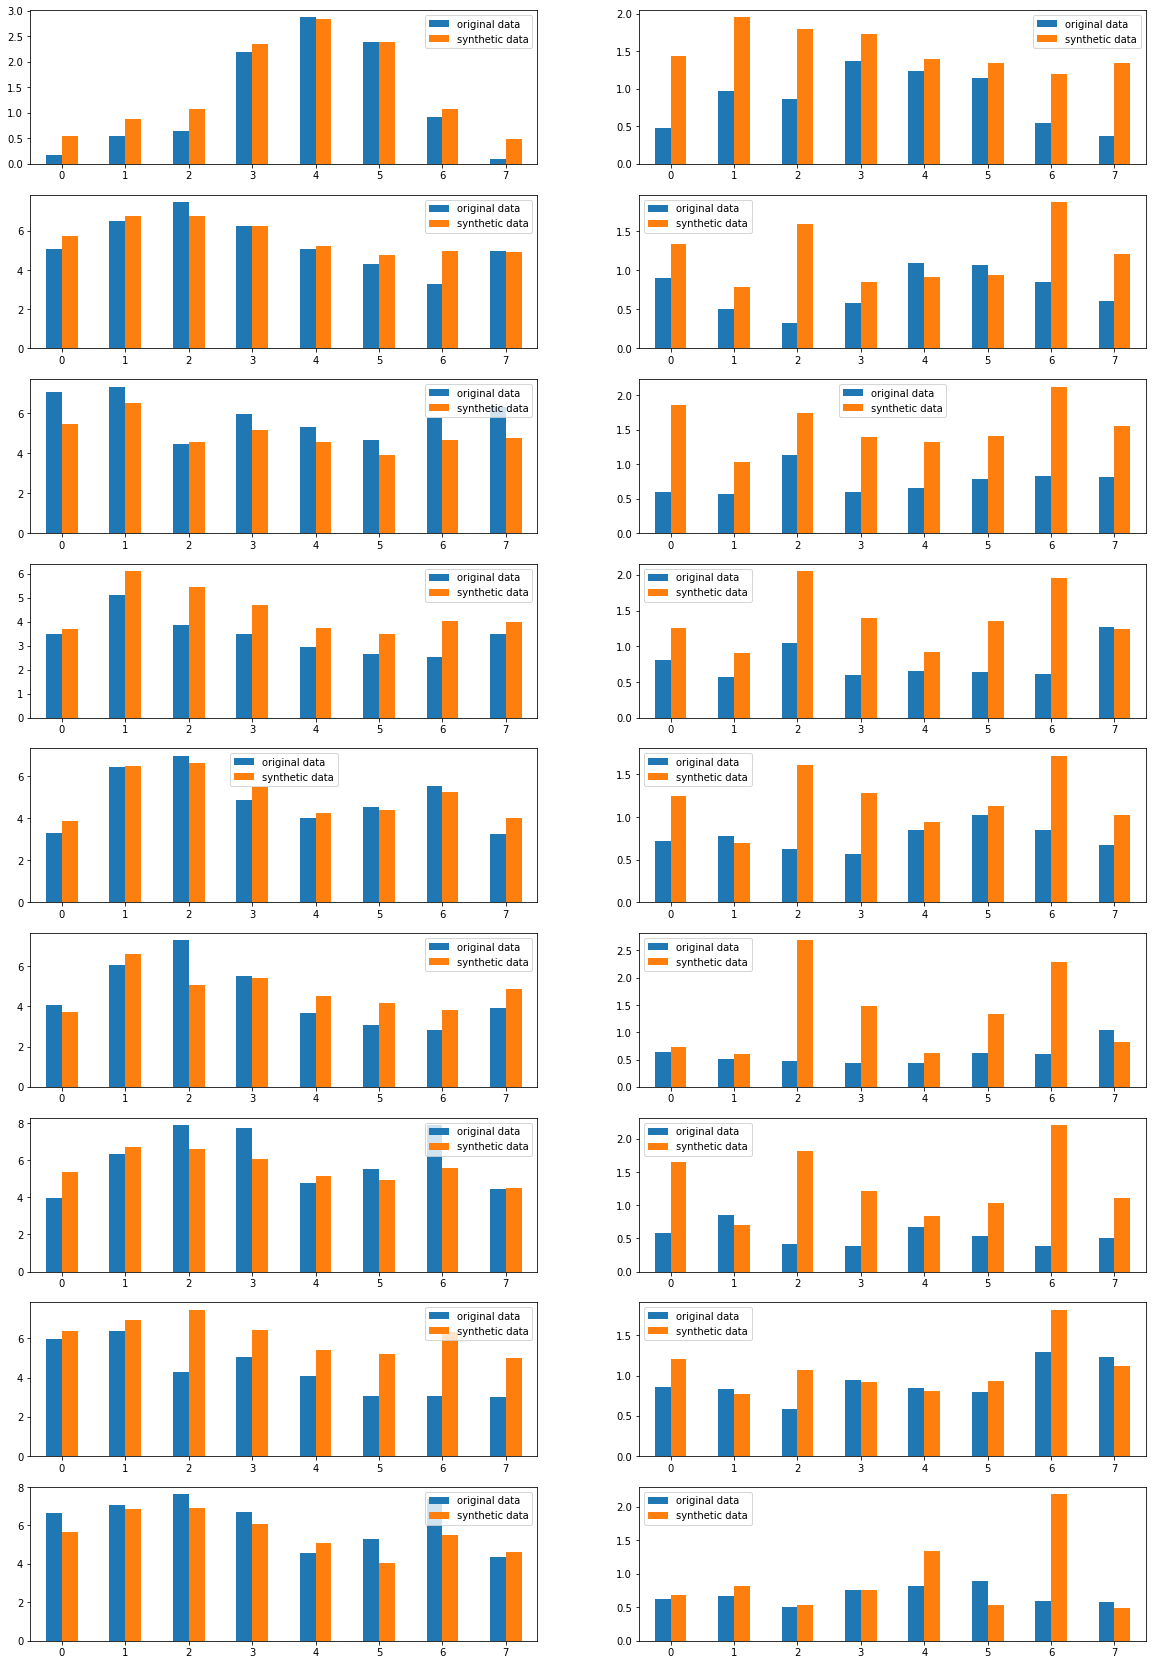

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(9, 2)

for i in range(9):
    results_single_codes_mean[i].plot.bar(rot=0, ax=axes[i,0], figsize=(20,30))
    results_single_codes_std[i].plot.bar(rot=0, ax=axes[i,1])

Zur Erinnerung: Jede Zeile entspricht einer Handbewegung mit den jeweils 8 Sensorwerten und zeigt die Werte für Originaldaten, sowie die synthetisch generierten Daten; linke Spalte: Mittelwerte; rechte Spalte: Standardabweichungen.
Die Ergebnisse sind, beurteilt nach Augenmaß, besser als im Multi-Table Modell. Vor allem die Mittelwerte für die Codes 1 und 2 sind wesentlich ähnlicher.

Für eine gesicherte Aussage, ob die generierten Daten als würdiger Ersatz bzw. würdige Erweiterung des Originaldatensatzes taugen, empfehlen wir eine weiterführende Evaluation über eine visuelle Betrachtung von Mittelwerten und Standardabweichung hinaus.